In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
sns.set()

In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
references = pd.read_csv("../data/references.csv").set_index("global_reference_id")
show(references)
references.head(10)

(28319, 2)


,title,abstract
global_reference_id,,
0,Distributed Representations of Words and Phras...,The recently introduced continuous Skip-gram...
1,BERT: Pre-training of Deep Bidirectional Trans...,We introduce a new language representation m...
2,GloVe : Global Vectors for Word Representation,Recent methods for learning vector space repre...
3,Attention Is All You Need,The dominant sequence transduction models ar...
4,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or..."
5,Long Short-Term Memory,NaN
6,Deep Contextualized Word Representations,We introduce a new type of deep contextualiz...
7,Efficient Estimation of Word Representations i...,We propose two novel model architectures for...
8,Neural Machine Translation By Jointly Learning...,Neural machine translation is a recently pro...


In [4]:
papers = pd.read_csv("../data/papers.csv").set_index("paper_id")
show(papers)

(1211, 3)


,title,abstract,text
paper_id,,,
2,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
3,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
4,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
5,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
6,Mental health consequences of infections by co...,"1The Department of Cerebrovascular Diseases, T...",Brain and Behavior. 2020;00:e01901. | 1 of 7 h...


In [5]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(62988, 6)


,paper_id,internal_reference_id,global_reference_id,context,start_offset,end_offset
0,1,0,8672,"JOURNAL OF COMBINATORIAL THEORY 9, 129--135 (1...",36,51
1,2,1,1,Our approach is mainly based on the BERT langu...,56,59
2,2,8,521,Different from many other ranking methods whic...,216,219
3,2,5,171,"Moreover, for full ranking subtask, we use a s...",78,81
4,2,6,27,The proposed model is based on the pointer-gen...,59,62


In [6]:
citations.groupby(["paper_id", "global_reference_id"]).size()

paper_id  global_reference_id
1         8672                   1
2         1                      2
          3                      1
          12                     1
          20                     1
                                ..
1364      21077                  1
          21363                  1
          21979                  1
          24086                  1
          25998                  1
Length: 36096, dtype: int64

# rouge against original abstract

In [7]:
retrieved = citations.groupby(["paper_id", "global_reference_id"]).context.sum().reset_index()
show(retrieved)

(36096, 3)


,paper_id,global_reference_id,context
0,1,8672,"JOURNAL OF COMBINATORIAL THEORY 9, 129--135 (1..."
1,2,1,Our approach is mainly based on the BERT langu...
2,2,3,BERT [2] is a self-supervised approach for pre...
3,2,12,"Recently, some variants [4, 12] of BERT langua..."
4,2,20,"Recently, some variants [4, 12] of BERT langua..."


In [8]:
retrieved.iloc[1].context

'Our approach is mainly based on the BERT language model [2], which is a state-of-the-art model in various natural language understanding tasks.BERT [2] is a self-supervised approach for pre-training a deep transformer encoder [8], before fine-tuning it for a particular downstream task.'

In [9]:
queries = retrieved.merge(references.drop(columns = "title"), on = "global_reference_id")\
.merge(papers.drop(columns = ["abstract", "title"]), on = "paper_id")\
.rename(columns = {"abstract":"reference", "context":"hypothesis", "text":"paper_text"})\
.dropna()\
.reset_index(drop = True)
show(queries)

(11467, 5)


,paper_id,global_reference_id,hypothesis,reference,paper_text
0,2,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation m...,"KEYWORDS cascade ranking, pre-trained language..."
1,2,3,BERT [2] is a self-supervised approach for pre...,The dominant sequence transduction models ar...,"KEYWORDS cascade ranking, pre-trained language..."
2,2,12,"Recently, some variants [4, 12] of BERT langua...",Language model pretraining has led to signif...,"KEYWORDS cascade ranking, pre-trained language..."
3,2,20,"Recently, some variants [4, 12] of BERT langua...",With the capability of modeling bidirectiona...,"KEYWORDS cascade ranking, pre-trained language..."
4,2,27,The proposed model is based on the pointer-gen...,Neural sequence-to-sequence models have prov...,"KEYWORDS cascade ranking, pre-trained language..."


In [10]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

11467


[{'rouge-1': {'r': 0.11504424778761062,
   'p': 0.3939393939393939,
   'f': 0.17808218828204173},
  'rouge-2': {'r': 0.013986013986013986,
   'p': 0.04878048780487805,
   'f': 0.021739126971290722},
  'rouge-l': {'r': 0.10619469026548672,
   'p': 0.36363636363636365,
   'f': 0.16438355814505543}},
 {'rouge-1': {'r': 0.03305785123966942,
   'p': 0.2222222222222222,
   'f': 0.057553954579990775},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.03305785123966942,
   'p': 0.2222222222222222,
   'f': 0.057553954579990775}},
 {'rouge-1': {'r': 0.07142857142857142,
   'p': 0.2916666666666667,
   'f': 0.11475409520021507},
  'rouge-2': {'r': 0.007936507936507936, 'p': 0.04, 'f': 0.013245030349546648},
  'rouge-l': {'r': 0.061224489795918366, 'p': 0.25, 'f': 0.09836065257726427}},
 {'rouge-1': {'r': 0.08163265306122448,
   'p': 0.3333333333333333,
   'f': 0.13114753782316588},
  'rouge-2': {'r': 0.007751937984496124, 'p': 0.04, 'f': 0.012987010267330642},
  'rouge-l': {'r': 0.

In [11]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(11467, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.11504424778761062, 'p': 0.393939393939...","{'r': 0.013986013986013986, 'p': 0.04878048780...","{'r': 0.10619469026548672, 'p': 0.363636363636..."
1,"{'r': 0.03305785123966942, 'p': 0.222222222222...","{'r': 0.0, 'p': 0.0, 'f': 0.0}","{'r': 0.03305785123966942, 'p': 0.222222222222..."
2,"{'r': 0.07142857142857142, 'p': 0.291666666666...","{'r': 0.007936507936507936, 'p': 0.04, 'f': 0....","{'r': 0.061224489795918366, 'p': 0.25, 'f': 0...."
3,"{'r': 0.08163265306122448, 'p': 0.333333333333...","{'r': 0.007751937984496124, 'p': 0.04, 'f': 0....","{'r': 0.07142857142857142, 'p': 0.291666666666..."
4,"{'r': 0.1320754716981132, 'p': 0.3181818181818...","{'r': 0.02962962962962963, 'p': 0.072727272727...","{'r': 0.12264150943396226, 'p': 0.295454545454..."


In [12]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(11467, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.115044,0.393939,0.178082
1,0.033058,0.222222,0.057554
2,0.071429,0.291667,0.114754
3,0.081633,0.333333,0.131148
4,0.132075,0.318182,0.186667


In [13]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(11467, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.013986,0.048780,0.021739
1,0.000000,0.000000,0.000000
2,0.007937,0.040000,0.013245
3,0.007752,0.040000,0.012987
4,0.029630,0.072727,0.042105


In [14]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(11467, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.106195,0.363636,0.164384
1,0.033058,0.222222,0.057554
2,0.061224,0.250000,0.098361
3,0.071429,0.291667,0.114754
4,0.122642,0.295455,0.173333


In [15]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(11467, 14)


,paper_id,global_reference_id,hypothesis,reference,paper_text,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,2,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation m...,"KEYWORDS cascade ranking, pre-trained language...",0.115044,0.393939,0.178082,0.013986,0.048780,0.021739,0.106195,0.363636,0.164384
1,2,3,BERT [2] is a self-supervised approach for pre...,The dominant sequence transduction models ar...,"KEYWORDS cascade ranking, pre-trained language...",0.033058,0.222222,0.057554,0.000000,0.000000,0.000000,0.033058,0.222222,0.057554
2,2,12,"Recently, some variants [4, 12] of BERT langua...",Language model pretraining has led to signif...,"KEYWORDS cascade ranking, pre-trained language...",0.071429,0.291667,0.114754,0.007937,0.040000,0.013245,0.061224,0.250000,0.098361
3,2,20,"Recently, some variants [4, 12] of BERT langua...",With the capability of modeling bidirectiona...,"KEYWORDS cascade ranking, pre-trained language...",0.081633,0.333333,0.131148,0.007752,0.040000,0.012987,0.071429,0.291667,0.114754
4,2,27,The proposed model is based on the pointer-gen...,Neural sequence-to-sequence models have prov...,"KEYWORDS cascade ranking, pre-trained language...",0.132075,0.318182,0.186667,0.029630,0.072727,0.042105,0.122642,0.295455,0.173333


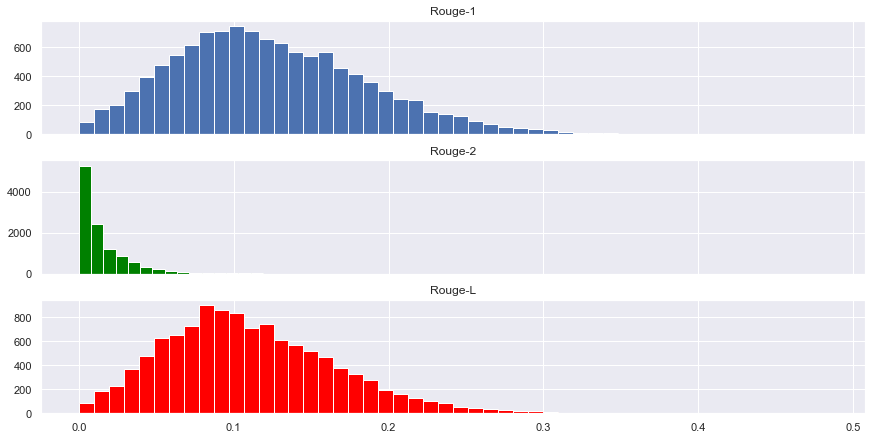

In [16]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

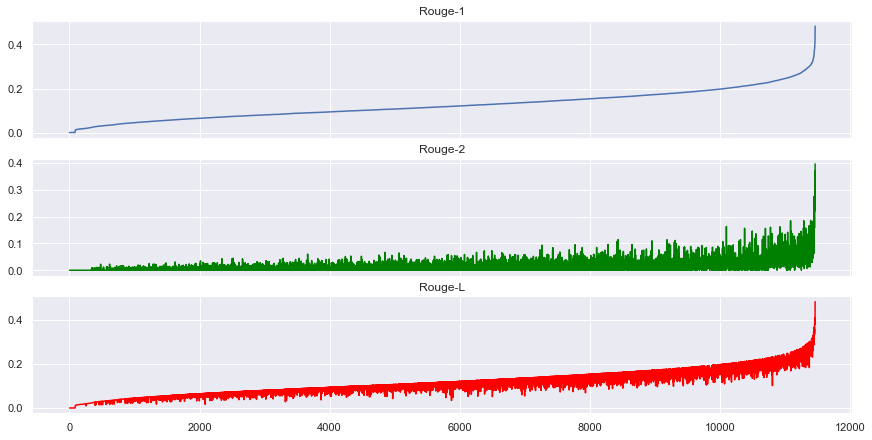

In [17]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

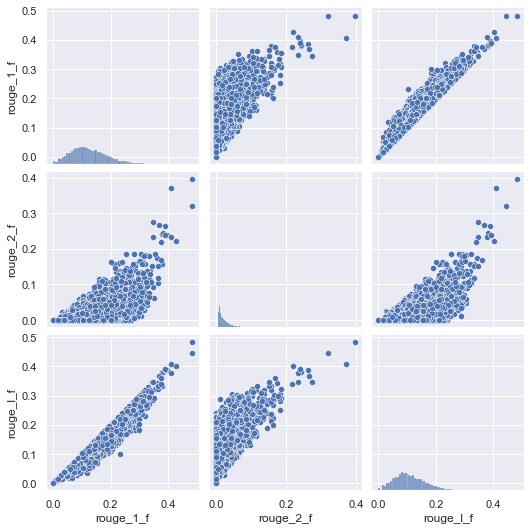

In [18]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

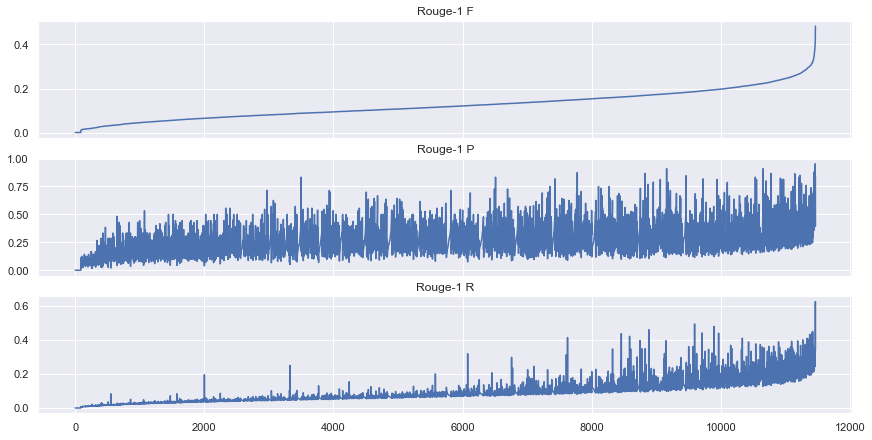

In [19]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

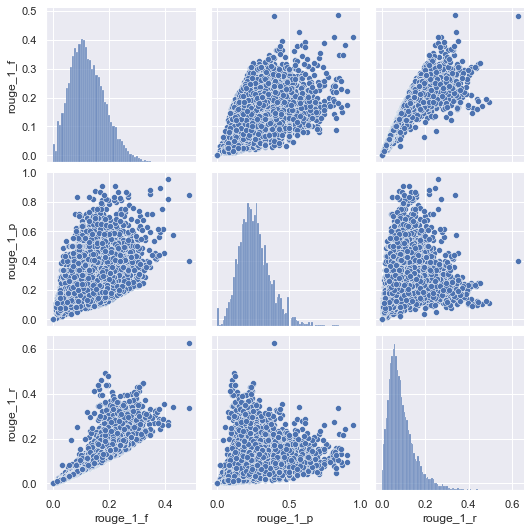

In [20]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

# building sentence tokenizer

In [21]:
tokenizer = PunktSentenceTokenizer(train_text = papers.text.sum())
tokenizer

In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device = "cuda")

In [23]:
data = queries.paper_text.head()
text_embeddings = []
for d in tqdm(data):
    sentences = tokenizer.tokenize(d)
    e = model.encode(sentences)
    text_embeddings.append(e)

  0%|          | 0/5 [00:00<?, ?it/s]